# Keras를 사용한 ML(머신러닝) 기본사항
## 5. 과적합 및 과소적합
### - 과대적합과 과소적합
#### 참고사이트 : https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [3]:
# 이번 예제는 4번 튜토리얼처럼 embedding을 사용하지 않고 multi-hot encoding으로 변환
# 이 모델은 훈련세트에 빠르게 overfitting 될꺼지만, 해결하는 방법에 초점을 맞추기 위해 실시
# 멀티핫인코딩은 정수 시퀀스를 0~1 vector로 변환(NUM_WORDS가 10000이기 때문에 10000차원 vector)
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # results[i]의 특정 인덱스만 1로 설정합니다
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

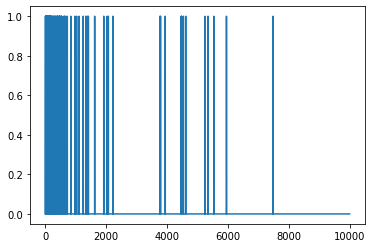

In [4]:
# 위에서 생성된 multi-hot vector 중 0번 확인
# 단어 index는 빈도 순으로 정렬되어 있기 때문에 0에 가까울수록 1이 많이 등장
plt.plot(train_data[0])

과대적합을 막는 가장 간단한 방법은 **모델의 규모를 축소**하는 것으로 **모델 파라미터(layer와 unit 개수에 의해 결정) 수를 줄여야 함.**   

딥러닝에서 모델의 학습 가능한 파라미터의 수를 모델의 "용량"이라 표현.   

포인트는 딥러닝 모델이 훈련 세트에서 학습이 잘 되는 것보다, **일반화** 라는 사실.   

어떤 모델의 적절한 크기나 구조를 결정하는 공식은 없기 때문에 여러 가지 다른 구조를 사용해 실험을 해봐야만 알 수 있음.   
알맞은 모델의 크기를 찾는 그나마 쉬운 방법은 **적은 수의 layer와 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 layer를 추가하거나 크기를 늘리는 것.**

위 내용을 기반으로 Dense 층만 사용하는 간단한 기준 모델을 만들고 작은 규모의 버전과
큰 버전의 모델을 만들어 비교.

In [5]:
# 기준 모델 만들기
baseline_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)), 
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
# epoch를 20번 반복하여 학습시키기
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2) # verbose 2이면 학습 과정 숫자로 다 보임

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.4791 - accuracy: 0.7973 - binary_crossentropy: 0.4791 - val_loss: 0.3302 - val_accuracy: 0.8784 - val_binary_crossentropy: 0.3302
Epoch 2/20
25000/25000 - 2s - loss: 0.2378 - accuracy: 0.9160 - binary_crossentropy: 0.2378 - val_loss: 0.2829 - val_accuracy: 0.8875 - val_binary_crossentropy: 0.2829
Epoch 3/20
25000/25000 - 2s - loss: 0.1716 - accuracy: 0.9411 - binary_crossentropy: 0.1716 - val_loss: 0.2979 - val_accuracy: 0.8837 - val_binary_crossentropy: 0.2979
Epoch 4/20
25000/25000 - 2s - loss: 0.1344 - accuracy: 0.9550 - binary_crossentropy: 0.1344 - val_loss: 0.3210 - val_accuracy: 0.8777 - val_binary_crossentropy: 0.3210
Epoch 5/20
25000/25000 - 2s - loss: 0.1092 - accuracy: 0.9659 - binary_crossentropy: 0.1092 - val_loss: 0.3522 - val_accuracy: 0.8738 - val_binary_crossentropy: 0.3522
Epoch 6/20
25000/25000 - 2s - loss: 0.0885 - accuracy: 0.9733 - binary_crossentropy: 0.0885 - val_loss: 0.3876

In [7]:
# 작은 모델 만들기
# 위의 기준 모델과 비교하기 위해 적은 수의 은닉 유닛을 가진 모델 생성
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [8]:
# epoch를 20번 반복하여 학습시키기
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=0) # verbose 0이면 학습 과정 안 보임

In [9]:
# 큰 모델 만들기
# 위의 기준 모델과 비교하여 얼마나 빠르게 과대적합이 시작되는지 보기 위함
# 이 문제에 필요한 것보다 훨씬 더 큰 용량을 가진 네트워크를 추가해 비교
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [10]:
# epoch를 20번 반복하여 학습시키기
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=1) # verbose 1이면 학습 과정 막대로 다 보임

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 6s 243us/sample - loss: 0.3561 - accuracy: 0.8481 - binary_crossentropy: 0.3561 - val_loss: 0.3051 - val_accuracy: 0.8756 - val_binary_crossentropy: 0.3051
Epoch 2/20
25000/25000 [==============================] - 5s 219us/sample - loss: 0.1494 - accuracy: 0.9446 - binary_crossentropy: 0.1494 - val_loss: 0.3323 - val_accuracy: 0.8712 - val_binary_crossentropy: 0.3323
Epoch 3/20
25000/25000 [==============================] - 6s 222us/sample - loss: 0.0538 - accuracy: 0.9835 - binary_crossentropy: 0.0538 - val_loss: 0.4382 - val_accuracy: 0.8690 - val_binary_crossentropy: 0.4382
Epoch 4/20
25000/25000 [==============================] - 5s 217us/sample - loss: 0.0074 - accuracy: 0.9990 - binary_crossentropy: 0.0074 - val_loss: 0.5795 - val_accuracy: 0.8686 - val_binary_crossentropy: 0.5795
Epoch 5/20
25000/25000 [==============================] - 6s 224us/sample - loss: 7.5086e-04 -

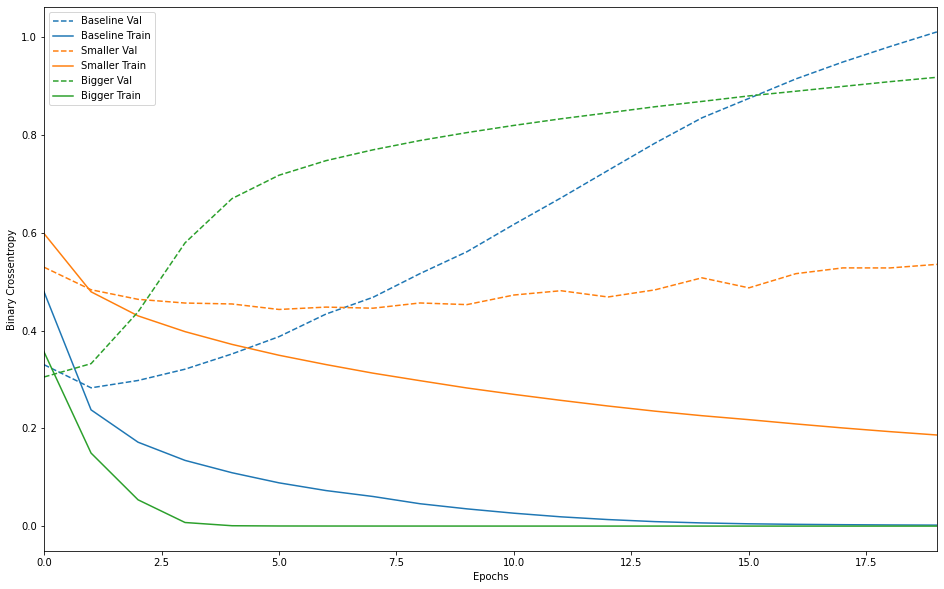

In [11]:
# 훈련 손실과 검증 손실 그래프 그리기
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

# 실선 = 훈련손실, 점선 = 검증손실 (검증손실이 낮을수록 더 좋은 모델)
# 작은 네트워크가 기준 모델보다 더 늦게 과대적합이 시작(epoch가 6에서 시작)
# 과대적합 시작되고 훨씬 천천히 성능 감소
# 큰 네트워크는 초반에 바로 과대적합 시작되고 빠름
# 즉, 네트워크의 용량이 많을수록 훈련 세트를 더 빠르게 모델링(훈련 손실이 낮아짐)할 수 있지만, 더 쉽게 과대적합됨(훈련 손실~검증 손실 사이 큰 차이 발생)

In [12]:
# 과대적합을 방지하기 위한 전략
# 1. 가중치 규제하기
# 오캄의 면도날(Occam's Razor) 이론 = 어떤 것을 설명하는 두 가지 방법이 있다면 더 정확한 설명은 최소한의 가정이 필요한 가장 간단한 설명
# 위 이론이 신경망 학습 모델에 적용(간단한 모델은 복잡한 모델보다 과대적합 덜 될 것)
# 간단한 모델 = 파라미터의 분포를 봤을 때 entropy가 작은 모델, 적은 파라미터를 가진 모델
# 즉, 가중치 규제 방법은 네트워크 복잡도에 제약을 가하는 것(손실함수에 큰 가중치 값 + -> 가중치 값의 분포를 좀 더 균일하게 만들어 줌)
# 1) L1 규제 = 가중치의 절댓값에 비례하는 값 +(가중치의 L1 norm +)
# 2) L2 규제(가중치 감쇠) = 가중치의 제곱에 비례하는 값 +(가중치의 L2 norm 제곱 +)
# L1보다는 L2를 더 많이 사용하며 이번 예제에서도 L2 방법 사용

l2_model = keras.models.Sequential([
    # l2(0.001)은 네트워크의 전체 손실에 layer에 있는 가중치 행렬의 모든 값이 0.001*(가중치제곱) 만큼 더해진다는 의미
    # 0.001을 곱해 가중치의 중요성을 낮춰버림(이런 panalty는 훈련시에만 추가 - 테스트보다 훈련 단계의 손실이 더 클 것)
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001), 
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.5330 - accuracy: 0.8064 - binary_crossentropy: 0.4941 - val_loss: 0.3799 - val_accuracy: 0.8751 - val_binary_crossentropy: 0.3393
Epoch 2/20
25000/25000 - 2s - loss: 0.3026 - accuracy: 0.9081 - binary_crossentropy: 0.2575 - val_loss: 0.3324 - val_accuracy: 0.8874 - val_binary_crossentropy: 0.2841
Epoch 3/20
25000/25000 - 2s - loss: 0.2510 - accuracy: 0.9298 - binary_crossentropy: 0.2005 - val_loss: 0.3352 - val_accuracy: 0.8858 - val_binary_crossentropy: 0.2829
Epoch 4/20
25000/25000 - 2s - loss: 0.2264 - accuracy: 0.9401 - binary_crossentropy: 0.1725 - val_loss: 0.3471 - val_accuracy: 0.8821 - val_binary_crossentropy: 0.2920
Epoch 5/20
25000/25000 - 2s - loss: 0.2129 - accuracy: 0.9467 - binary_crossentropy: 0.1564 - val_loss: 0.3655 - val_accuracy: 0.8786 - val_binary_crossentropy: 0.3081
Epoch 6/20
25000/25000 - 2s - loss: 0.1997 - accuracy: 0.9528 - binary_crossentropy: 0.1415 - val_loss: 0.3785

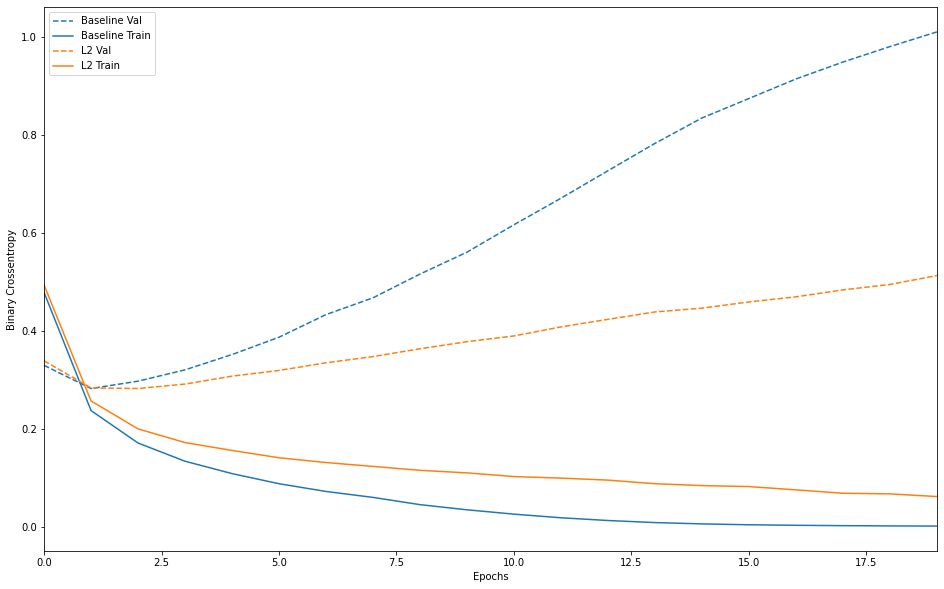

In [13]:
# 파라미터가 같지만 L2규제를 가한 모델이 기존 모델보다 과대적합에 훨씬 잘 견딤.
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

In [14]:
# 드롭아웃 추가하기
# dropout은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나(토론토 대학의 Hinton과 제자들이 개발)
# 이를 layer에 적용하면 훈련하는 동안 출력 특성을 랜덤하게 0으로 만듬
# 드롭아웃 비율은 0이 되는 특성의 비율로 보통 0.2~0.5 사이 값을 사용
# 대신 적은 양으로 학습을 해야하기 때문에 시간이 오래 걸린다는 단점이 있음
# 테스트 단계에서는 어떤 unit도 dropout 하지 않음
# tf.keras에서는 Dropout() 함수를 통해 바로 이전 층의 출력에 드롭아웃을 추가 할 수 있음.
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.6418 - accuracy: 0.6282 - binary_crossentropy: 0.6418 - val_loss: 0.5243 - val_accuracy: 0.8412 - val_binary_crossentropy: 0.5243
Epoch 2/20
25000/25000 - 2s - loss: 0.4788 - accuracy: 0.7919 - binary_crossentropy: 0.4788 - val_loss: 0.3577 - val_accuracy: 0.8775 - val_binary_crossentropy: 0.3577
Epoch 3/20
25000/25000 - 2s - loss: 0.3640 - accuracy: 0.8640 - binary_crossentropy: 0.3640 - val_loss: 0.2940 - val_accuracy: 0.8881 - val_binary_crossentropy: 0.2940
Epoch 4/20
25000/25000 - 2s - loss: 0.2930 - accuracy: 0.8962 - binary_crossentropy: 0.2930 - val_loss: 0.2803 - val_accuracy: 0.8871 - val_binary_crossentropy: 0.2803
Epoch 5/20
25000/25000 - 2s - loss: 0.2453 - accuracy: 0.9156 - binary_crossentropy: 0.2453 - val_loss: 0.2789 - val_accuracy: 0.8890 - val_binary_crossentropy: 0.2789
Epoch 6/20
25000/25000 - 2s - loss: 0.2134 - accuracy: 0.9309 - binary_crossentropy: 0.2134 - val_loss: 0.2844

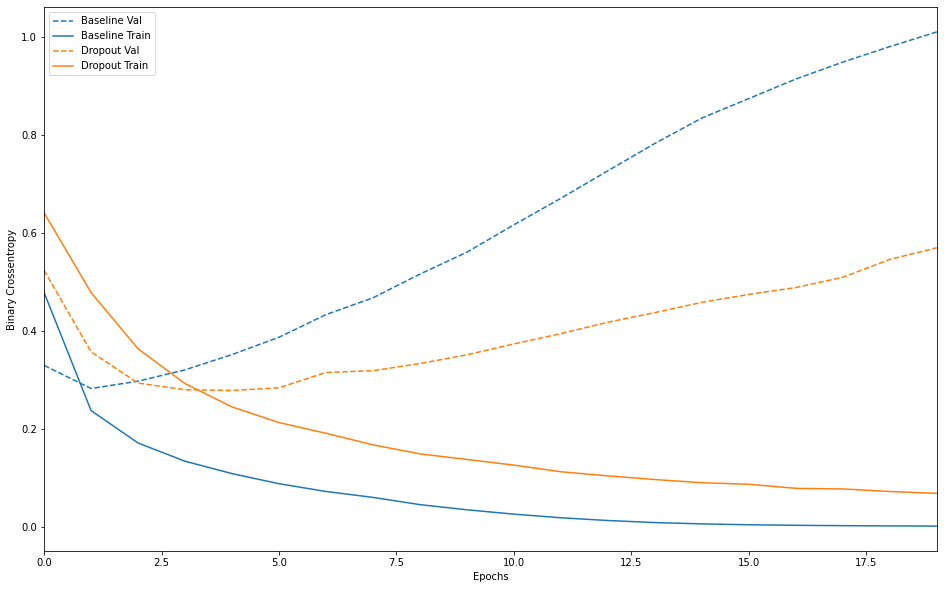

In [15]:
# 기준모델보다 확실히 향상됨(epoch가 느리게 과대적합이 나타남)
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

신경망에 과대적합 방지하기 위한 방법은 다음과 같음
* 더 많은 훈련 데이터 모으기
* 네트워크 용량 줄이기
* 가중치 규제 추가
* 드롭아웃 추가